In [3]:
import os

import pandas as pd
from torch import nn, optim, device, cuda
import torch

import yaml
from tqdm.notebook import tqdm, trange

import logging
import wandb
from tensorboardX import SummaryWriter

from data_parser import adj_matrix, nodes
from image_parser import train_loader, test_loader, debug_loader
from utils import log_training_images

from models import CombinedModel
from model_config_manager import ModelConfigManager

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
config = yaml.safe_load(open("config.yml"))
DEBUG = config["DEBUG"]
epochs = config["EPOCHS"] if not DEBUG else 2
RETINA_MODEL = config["RETINA_MODEL"]
images_fraction = config["IMAGES_FRACTION"]
continue_training = config["CONTINUE_TRAINING"]
saved_model_path = config["SAVED_MODEL_PATH"]
model_name = config["MODEL_NAME"]
save_every = config["SAVE_EVERY"]
layer_number = config["LAYER_NUMBER"]

loader = debug_loader if DEBUG else train_loader

logging.basicConfig(
    filename="training_log.log", 
    level=logging.DEBUG if DEBUG else logging.INFO, 
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger("training_log")

dev = device("cuda" if cuda.is_available() else "cpu")    
if dev.type == "cpu":
    logger.warning("WARNING: Running on CPU, so it might be slow")

# Create the ModelConfigManager and load configurations from YAML files
config_manager = ModelConfigManager()

# Get a specific configuration by model name
config_manager.set_model_config(RETINA_MODEL)

In [6]:
combined_model = CombinedModel(adj_matrix, neurons=nodes, model_config=config_manager.model_config)

if continue_training:
    # If we want to continue training a saved model
    combined_model.load_state_dict(torch.load(saved_model_path))

combined_model = combined_model.to(dev)

# Logs
wandb.init(project="connectome", config=config_manager.model_config)
# I also want the model architecture
tensorboard_writer = SummaryWriter()

# Specify the loss function and the optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.00001)
_ = wandb.watch(combined_model, criterion, log="all") 


wandb: Currently logged in as: eudald. Use `wandb login --relogin` to force relogin


In [ ]:
config_manager.output_model_details()
if DEBUG:
    logger.warning("WARNING: Running on DEBUG mode, so using 10% of the images")
elif images_fraction < 1:
    logger.warning(f"WARNING: Using {images_fraction * 100}% of the images")

for epoch in trange(epochs):
    running_loss = 0
    correct_predictions = 0
    # If the model is fast~ish
    # for images, labels in train_loader:
    for images, labels in tqdm(loader):

        # Move images and labels to the device
        images, labels = images.to(dev), labels.to(dev)

                # Log model architecture to tensorboard
        if epoch == 0:
            tensorboard_writer.add_graph(combined_model, images)
            
        # Forward pass
        outputs = combined_model(images)

        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Compute the accuracy
        predicted_labels = torch.argmax(outputs, dim=1)
        correct_predictions = (predicted_labels == labels).sum().item()
        accuracy = correct_predictions / len(labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update loss
        running_loss += loss.item()
        
        # Logs to wandb
        wandb.log({"loss": loss.item(), "accuracy": accuracy, "epoch": epoch})
        log_training_images(images, labels, outputs)

    logger.info(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')
    
    # Save model
    if (epoch + 1) % save_every == 0:
        torch.save(combined_model.state_dict(), os.path.join("models", f"model:{RETINA_MODEL}_layers:{layer_number}_epochs:{epoch + 1}_{model_name}.pth"))
        logger.info(f"Saved model after {epoch + 1} runs")

# Close logs
wandb.finish()
tensorboard_writer.close()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
# torch.save(combined_model.state_dict(), os.path.join("models", f"model_{RETINA_MODEL}_{epoch + 1}_epochs.pth"))

In [5]:
# Test de model
correct = 0
total = 0
test_results_df = pd.DataFrame(columns=["Image", "Real Label", "Predicted Label", "Correct Prediction"])

j = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(dev), labels.to(dev)
        outputs = combined_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        # Convert the tensor values to CPU and numpy
        labels_cpu = labels.cpu().numpy()
        predicted_cpu = predicted.cpu().numpy()
        
        # Check if the prediction is correct
        correct_predictions = (predicted == labels)
        correct_cpu = correct_predictions.cpu().numpy()
        
        image_names = [a[0] for a in test_loader.dataset.dataset.samples[j * test_loader.batch_size: (j + 1) * test_loader.batch_size]]
        j += 1
        
        batch_df = pd.DataFrame({
            "Image": image_names,
            "Real Label": labels_cpu,
            "Predicted Label": predicted_cpu,
            "Correct Prediction": correct_cpu.astype(int)
        })
        
        # Append the batch DataFrame to the list
        test_results_df = pd.concat([test_results_df, batch_df], ignore_index=True)

logger.info(f"Accuracy on the {total} test images: {100 * correct / total}%")

  0%|          | 0/250 [00:00<?, ?it/s]

NameError: name 'logger' is not defined

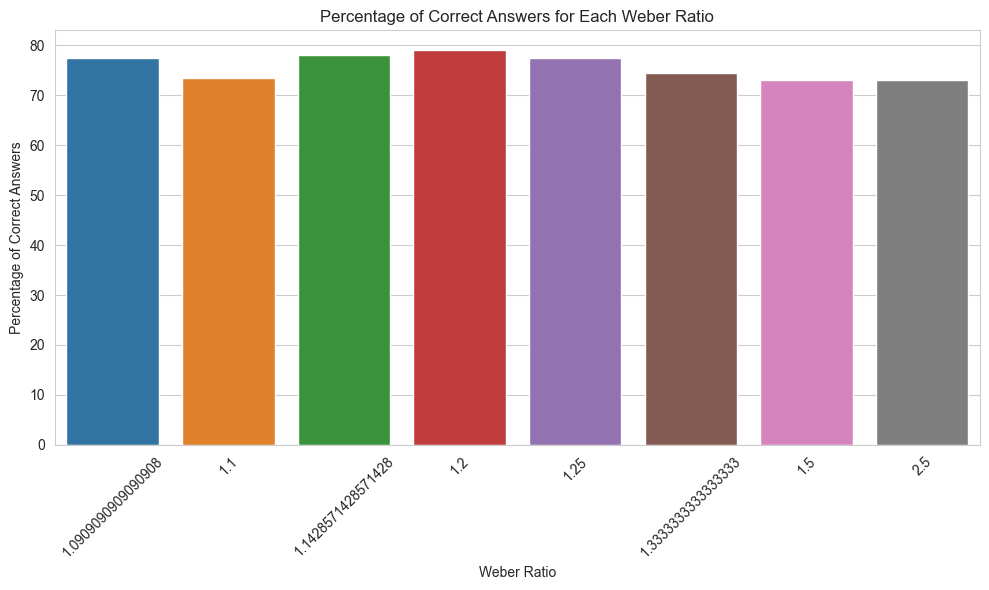

In [7]:
# Calculate the percentage of correct answers for each Weber ratio
test_results_df['yellow'] = test_results_df['Image'].apply(lambda x: x.split('_')[1])
test_results_df['blue'] = test_results_df['Image'].apply(lambda x: x.split('_')[2])
test_results_df['weber_ratio'] = test_results_df.apply(lambda row: max(int(row['yellow']), int(row['blue'])) / min(int(row['yellow']), int(row['blue'])), axis=1)
correct_percentage = test_results_df.groupby('weber_ratio')['Correct Prediction'].mean() * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correct_percentage.index, y=correct_percentage.values)
plt.xlabel('Weber Ratio')
plt.ylabel('Percentage of Correct Answers')
plt.title('Percentage of Correct Answers for Each Weber Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
100 * correct / total

tensor(75.6500, device='cuda:0')